## Imports

In [1]:
!pip install opencv-python ultralytics -q
import warnings
warnings.filterwarnings("ignore")
import os
import shutil
import numpy as np
np.bool = np.bool_
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2

import xml.etree.ElementTree as ET
from imgaug import augmenters as iaa
import imgaug as ia

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image as tf_image
from sklearn.utils.class_weight import compute_class_weight

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Samples of Standford Dogs Dataset

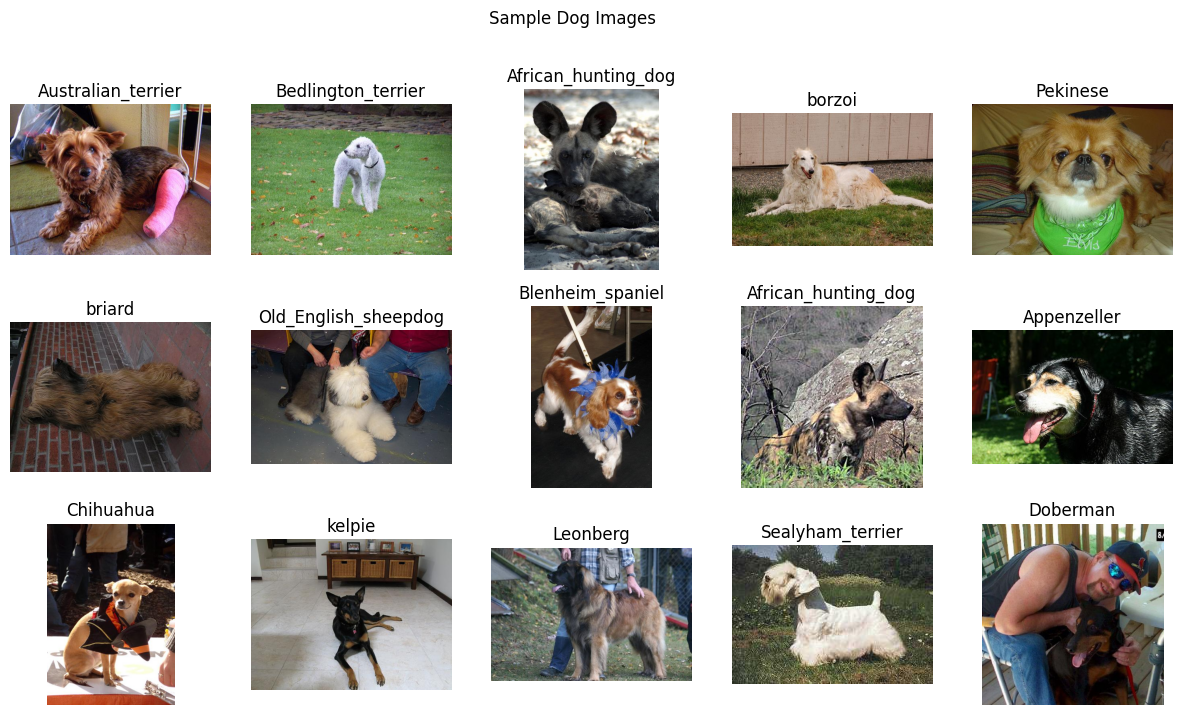

In [2]:
"""
Randomly selects and displays 15 sample dog images from the dataset, 
along with the breed name extracted from the annotation files.
"""

annotation_path = '/kaggle/input/stanford-dogs-dataset/annotations/Annotation/'
image_path = '/kaggle/input/stanford-dogs-dataset/images/Images/'

breed_list = os.listdir(annotation_path)
fig = plt.figure(figsize=(15,8))
for i in range(15):
    axs = fig.add_subplot(3,5,i+1)
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir(annotation_path + breed))
    img = Image.open(image_path + breed + '/' + dog + '.jpg')
    tree = ET.parse(annotation_path + breed + '/' + dog)
    root = tree.getroot()
    object_1 = root.findall('object')[0]
    name = object_1.find('name').text;
    axs.set_title(name)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("Sample Dog Images")
plt.show()

## Cropping Images

In [3]:
"""
Creating data folder for all cropped images and extracting images of each dog breed to separate folder
"""

breed_list = os.listdir("../input/stanford-dogs-dataset/images/Images/")

os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('../input/stanford-dogs-dataset/annotations/Annotation/{}'.format(breed)):
        img = Image.open('../input/stanford-dogs-dataset/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('../input/stanford-dogs-dataset/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.


## Train/Test Split

In [4]:
"""
Creating a folder for cropped images (reduced background) and extracting images of each dog breed into separate folders for training and testing.
"""

original_data_dir = '/kaggle/working/data'
train_data_dir = '/kaggle/working/train_data'
test_data_dir = '/kaggle/working/test_data'

# Create folders if they don't exist
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)

# Iterate over each class/breed
for class_name in os.listdir(original_data_dir):
    class_dir = os.path.join(original_data_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        
        # Train/Test split
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        
        # Create corresponding folders for each class
        train_class_dir = os.path.join(train_data_dir, class_name)
        test_class_dir = os.path.join(test_data_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        # Copy images to respective folders
        for image in train_images:
            shutil.copy(os.path.join(class_dir, image), os.path.join(train_class_dir, image))
        
        for image in test_images:
            shutil.copy(os.path.join(class_dir, image), os.path.join(test_class_dir, image))

## Data Augmenation

In [5]:
"""
Defining a custom data generator class for image data augmentation. 
It loads images from the dataset, applies various augmentations (like flipping, cropping, blurring, etc.), 
and prepares batches for training in a deep learning model.
"""

# Setting a random seed
ia.seed(1)

# Data augmentation definition
seq = iaa.Sequential([
    iaa.OneOf([
        iaa.Fliplr(0.5),  # Randomly flips the image horizontally
        iaa.CropAndPad(percent=(-0.1, 0.1)),  # Cropping and adding padding
        iaa.Crop(percent=(0, 0.1)),  # Randomly crops images
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.3))),  # Occasionally adds Gaussian blur
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # Scales the image
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # Translates the image
            rotate=(-20, 20),  # Rotates the image
            shear=(-8, 8)  # Applies shear transformation
        )
    ])
], random_order=True)

class AugmentedImageDataGenerator(Sequence):
    def __init__(self, image_dir, batch_size, image_size, seq, shuffle=True):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.seq = seq
        self.shuffle = shuffle
        self.class_names = sorted(os.listdir(image_dir))
        self.class_indices = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.image_paths = []
        self.labels = []
        
        for class_name in self.class_names:
            class_dir = os.path.join(image_dir, class_name)
            for fname in os.listdir(class_dir):
                if fname.endswith('.jpg'):  # Filter only image files
                    self.image_paths.append(os.path.join(class_dir, fname))
                    self.labels.append(self.class_indices[class_name])
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = np.array([self.load_image(img_path) for img_path in batch_paths])
        labels = np.array(batch_labels)
        
        # Augmenting images
        images_aug = self.seq(images=images)
        
        return preprocess_input(images_aug), labels
    
    def load_image(self, img_path):
        # Loads the image and resizes it to the specified size
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.image_size, self.image_size))
        return img
    
    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)
            
#     def __iter__(self):
#         """Make the object an iterator."""
#         for i in range(len(self)):
#             yield self.__getitem__(i)

## Data generators

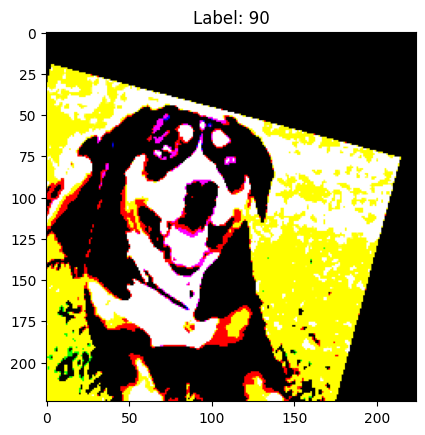

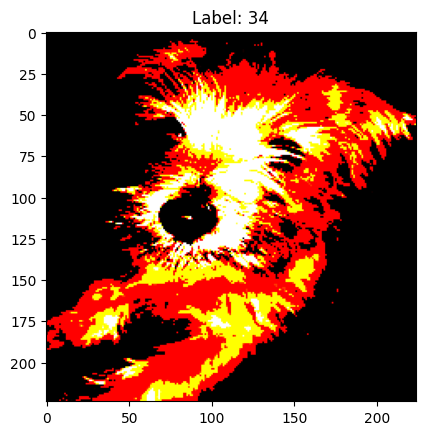

In [7]:
"""
Setting up data generators for training and testing, including data augmentation for the training set. 
It also defines callbacks for model checkpointing, learning rate reduction, and early stopping during training.
"""

batch_size = 32
image_size = 224

# Data generator with data augmentation for the training set
train_generator = AugmentedImageDataGenerator(
    image_dir=train_data_dir,
    batch_size=batch_size,
    image_size=image_size,
    seq=seq,  # Augmentation using imgaug
    shuffle=True
)

# Data generator for the test set (without augmentation)
test_generator = AugmentedImageDataGenerator(
    image_dir=test_data_dir,
    batch_size=batch_size,
    image_size=image_size,
    seq=iaa.Noop(), # No augmentation
    shuffle=False 
)

# Callback to save the best model (when val_acc increases)
checkpoint = ModelCheckpoint(
    'dog_breed_classifier_model.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max', 
    save_weights_only=True
)

# Callback to reduce learning rate when val_loss does not improve
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate by a factor of 0.2
    patience=1,
    verbose=1,
    mode='min',
    min_delta=0.0001, # Minimum change to qualify as an improvement
    cooldown=2, # Cooldown period (how many epochs to wait after reducing)
    min_lr=1e-7
)

# Callback for early stopping if val_loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5, 
    verbose=1 
)

# Sanity check
images, labels = next(iter(train_generator))
for i in range(2):
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()

## Breed weights (optional)

In [12]:
"""
Calculating the class weights based on the number of images in each class 
to handle class imbalance in the dataset. It counts the number of images in each class folder,
displays the counts, and computes the weights for each class.
"""

# Count the number of images in each folder (class)
class_names = []
class_counts = []

for class_folder in os.listdir(original_data_dir):
    class_path = os.path.join(original_data_dir, class_folder)
    if os.path.isdir(class_path):  
        num_images = len(os.listdir(class_path))  
        class_names.append(class_folder)  
        class_counts.append(num_images)  

# Number of classes
num_classes = len(class_names)

# Vector of class labels
class_indices = np.arange(num_classes)

# Calculate class weights
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=class_indices,
    y=np.repeat(class_indices, class_counts)  # Repeat labels based on counts
)

# Create a dictionary of class weights
class_weight_dict = dict(zip(class_indices, class_weight))

## Model

In [16]:
"""
Model initialization using the ResNet50 backbone pre-trained on ImageNet.
"""

# Loading model backbone (ResNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freezing ResNet layers
for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(120, activation='softmax')(x)  # 120 class for each breed

model = models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training

In [17]:
"""
Initial training of the model for 20 epochs 
and then fine-tuning the last 30 layers of the model.
"""

# Initial Training
train_history = model.fit(
    train_generator,
    validation_data=test_generator, 
    epochs=20,
    steps_per_epoch=len(train_generator),
    class_weight=class_weight_dict
)

for layer in model.layers[-30:]:
    layer.trainable = True

# Training
tune_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    class_weight=class_weight_dict,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

Epoch 1/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 72s 116ms/step - accuracy: 0.2808 - loss: 3.0840 - val_accuracy: 0.6474 - val_loss: 1.1375
Epoch 2/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6474 - val_loss: 1.1375
Epoch 3/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - accuracy: 0.5862 - loss: 1.3840 - val_accuracy: 0.6928 - val_loss: 0.9929
Epoch 4/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6928 - val_loss: 0.9929
Epoch 5/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - accuracy: 0.6409 - loss: 1.1859 - val_accuracy: 0.6933 - val_loss: 0.9966
Epoch 6/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6933 - val_loss: 0.9966
Epoch 7/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - accuracy: 0.6747 - loss: 1.0601 - val_accuracy: 0.7075 - val_loss: 0.9408
Epoch 8/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accura

## Locating dogs on sample

100%|██████████| 6.25M/6.25M [00:00<00:00, 193MB/s]



0: 448x640 4 dogs, 49.0ms
Speed: 3.7ms preprocess, 49.0ms inference, 247.6ms postprocess per image at shape (1, 3, 448, 640)


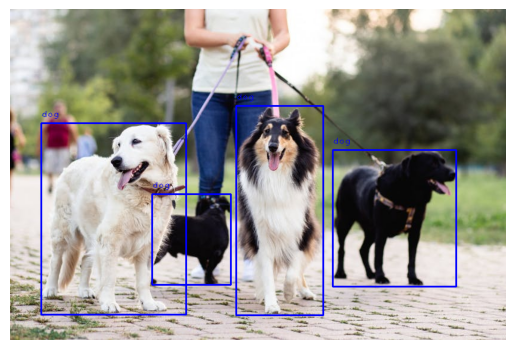

In [18]:
"""
Using a YOLOv8 model to detect dogs in an image. It defines functions for making predictions and 
drawing bounding boxes around detected dogs, and then demonstrates the detection on a sample image.
"""

yolov8 = YOLO("yolov8n.pt")

def predict(chosen_model, img, classes=[], conf=0.5):
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf)
    else:
        results = chosen_model.predict(img, conf=conf)

    return results


def predict_and_detect(chosen_model, img, classes=[], conf=0.5):
    results = predict(chosen_model, img, classes, conf=conf)

    classic_img=img.copy()
    dog_crop=[]

    for result in results:
        for box in result.boxes:
            cv2.rectangle(img, (int(box.xyxy[0][0]), int(box.xyxy[0][1])),
                          (int(box.xyxy[0][2]), int(box.xyxy[0][3])), (255, 0, 0), 2)
            cv2.putText(img, f"{result.names[int(box.cls[0])]}",
                        (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10),
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1)
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            dog_crop.append(classic_img[y1:y2, x1:x2])

    return img, dog_crop

# read sample and detect dogs
image = cv2.imread('/kaggle/input/dogs-classification/sample2.jfif')
result_img = predict_and_detect(yolov8, image, classes=[16], conf=0.5)
plt.imshow(cv2.cvtColor(result_img[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Sample preprocessing

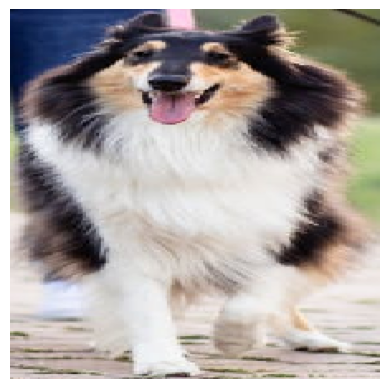

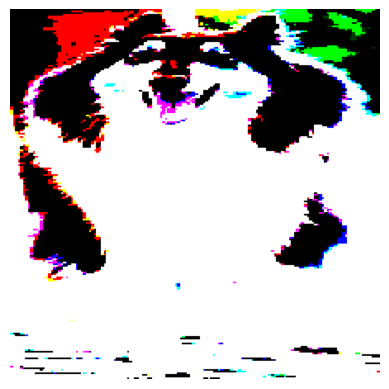

In [19]:
"""
Loading an image, resizes it to the input dimensions expected by the model, 
and prepares the image for prediction by converting it to a NumPy array and normalizing the pixel values.
"""

# Loading
img_path = '/kaggle/input/dogs-classification/3.png'
img = tf_image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.show()

# Preparing for prediction
img_array = tf_image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
plt.imshow(img_array[0])
plt.axis('off')
plt.show()

## Result

In [20]:
"""
Retriving the class mapping from the training data generatorand displays the top 3 predicted breeds along with their probabilities.
"""

# Get the class mapping from the training data generator
class_indices = train_generator.class_indices

# Reverse the class index mapping to obtain an inverse mapping: index -> breed name
labels = dict((v, k) for k, v in class_indices.items())

# Prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)

# Print the predicted dog breed
predicted_class_label = labels[predicted_class_index[0]]
print("Predicted dog breed:", predicted_class_label)

# Top 3 predictions
for i in np.argsort(predictions[0])[-3:][::-1]:
    predicted_class_label = labels[i]  # Class name
    probability = predictions[0][i] * 100  # Probability in %
    print(f"{probability:.2f}% \t {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted dog breed: n02106030-collie
52.39% 	 n02106030-collie
46.92% 	 n02105855-Shetland_sheepdog
0.42% 	 n02106166-Border_collie


## Loading best weights

In [ ]:
model.load_weights('dog_breed_classifier_model.weights.h5')
model.save('Model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('Model.tflite', 'wb') as f:
    f.write(tflite_model)